---------

# Leakage Analysis on DPA contest V2 AES Intermediate Data

we are using the scared library and home made code. 
    
--------

In [1]:
import estraces
import scared

In [2]:
import numpy as np

In [3]:
ths = estraces.read_ths_from_ets_file('../Traces/AES_dpa_contest-v2.ets')
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../Traces/AES_dpa_contest-v2.ets with 20000 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['figure.figsize']=(16,4)

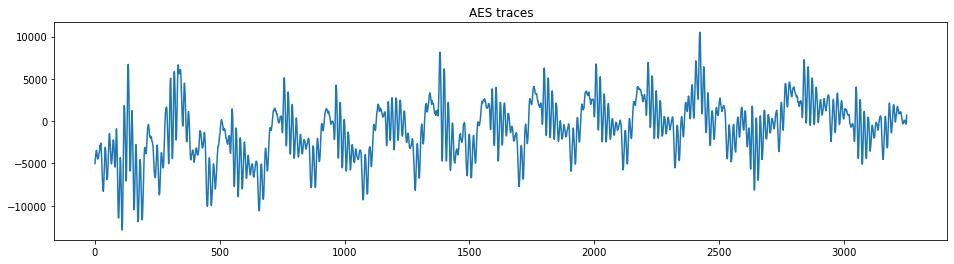

In [6]:
plt.plot(ths.samples[0:1].T)
plt.title('AES traces')
plt.show()

In [7]:
ths.metadata_tags

['ciphertext', 'key', 'plaintext']

### Select your distinguisher

In [8]:
Distinguisher = scared.CPAReverse
#Distinguisher = scared.SNRReverse
#Distinguisher = scared.ANOVAReverse
#Distinguisher = scared.NICVReverse

### Select your model

In [9]:
model_selected=scared.HammingWeight()
#model=scared.Value()
#model=scared.Monobit()    # and set the bit value

### Reverse on Plaintext and Ciphertext

In [10]:
import scared

In [11]:
container = scared.Container(ths)

In [12]:
@scared.reverse_selection_function
def identity_plaintext(plaintext):
    return plaintext

@scared.reverse_selection_function
def identity_ciphertext(ciphertext):
    return ciphertext

In [13]:
reverse_plaintext = Distinguisher(selection_function=identity_plaintext, model = model_selected)
reverse_ciphertext = Distinguisher(selection_function=identity_ciphertext, model = model_selected)
reverse_plaintext.run(container)
reverse_ciphertext.run(container)

### Saving the results

In [14]:
dist = 'cpa'
mod = 'HW'

In [15]:
np.save('leakage_plaintext_'+dist+'_'+mod, reverse_plaintext.results)
np.save('leakage_ciphertext_'+dist+'_'+mod, reverse_ciphertext.results)

### Plot results

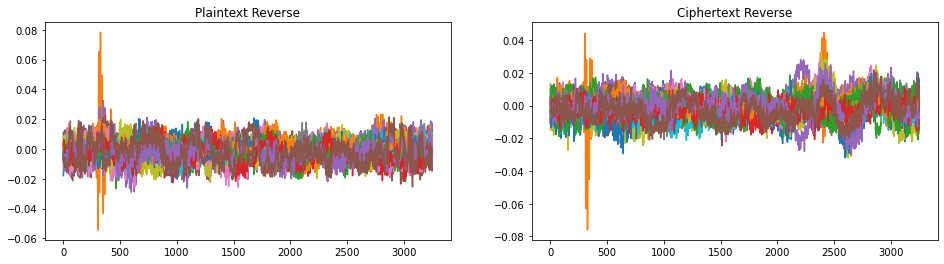

In [16]:
plt.subplot(121)
plt.plot(reverse_plaintext.results.T)
plt.title('Plaintext Reverse')
plt.subplot(122)
plt.plot(reverse_ciphertext.results.T)
plt.title('Ciphertext Reverse')
plt.show()

----
## Reverse on intermediate values - First round

In [17]:
def aes_function_firstRde_AddKey(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=0, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)

def aes_function_firstRde_SBout(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SUB_BYTES)

def aes_function_firstRde_2X(plaintext, key):
    return scared.aes.XTIME_2[scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SUB_BYTES)]

def aes_function_firstRde_3X(plaintext, key):
    return scared.aes.XTIME_3[scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SUB_BYTES)]

def aes_function_firstRde_ShiftRow(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SHIFT_ROWS)

def aes_function_firstRde_MixColumn(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.MIX_COLUMNS)

def aes_function_DeltaR0R1(plaintext, key):
    tmp1 = plaintext
    tmp2 = scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.MIX_COLUMNS)    
    return tmp1^tmp2

def aes_function_DeltaR0R1_2keysAdd(plaintext, key):
    tmp1 = scared.aes.encrypt(plaintext = plaintext, key = key, at_round=0, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)    
    tmp2 = scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)
    return tmp1^tmp2

In [18]:
Sel_AdK = scared.reverse_selection_function(aes_function_firstRde_AddKey)
Sel_SB = scared.reverse_selection_function(aes_function_firstRde_SBout)
Sel_2xSB = scared.reverse_selection_function(aes_function_firstRde_2X)
Sel_3xSB = scared.reverse_selection_function(aes_function_firstRde_3X)
Sel_SR = scared.reverse_selection_function(aes_function_firstRde_ShiftRow)
Sel_MXC = scared.reverse_selection_function(aes_function_firstRde_MixColumn)
Sel_R0R1 = scared.reverse_selection_function(aes_function_DeltaR0R1)
Sel_R0R1_2keysAdd = scared.reverse_selection_function(aes_function_DeltaR0R1_2keysAdd)

In [19]:
Reverse_AdK = Distinguisher(selection_function = Sel_AdK, model = model_selected)
Reverse_SB = Distinguisher(selection_function = Sel_SB, model = model_selected)
Reverse_2xSB = Distinguisher(selection_function = Sel_2xSB, model = model_selected)
Reverse_3xSB = Distinguisher(selection_function = Sel_3xSB, model = model_selected)
Reverse_SR = Distinguisher(selection_function = Sel_SR, model = model_selected)
Reverse_MXC = Distinguisher(selection_function = Sel_MXC, model = model_selected)
Reverse_R0R1 = Distinguisher(selection_function = Sel_R0R1, model = model_selected)
Reverse_R0R1_2keysAdd = Distinguisher(selection_function = Sel_R0R1_2keysAdd, model = model_selected)

In [20]:
Reverse_AdK.run(container)
Reverse_SB.run(container)
Reverse_2xSB.run(container)
Reverse_3xSB.run(container)
Reverse_SR.run(container)
Reverse_MXC.run(container)
Reverse_R0R1.run(container)
Reverse_R0R1_2keysAdd.run(container)

### Saving the results

In [21]:
dist = 'cpa'
mod = 'HW'

In [22]:
np.save('leakage_AES_Rde1_KeyAdd_'+dist+'_'+mod, Reverse_AdK.results)
np.save('leakage_AES_Rde1_SR_'+dist+'_'+mod, Reverse_SR.results)
np.save('leakage_AES_Rde1_SB_'+dist+'_'+mod, Reverse_SB.results)
np.save('leakage_AES_Rde1_2xSB_'+dist+'_'+mod, Reverse_2xSB.results)
np.save('leakage_AES_Rde1_3xSB_'+dist+'_'+mod, Reverse_3xSB.results)
np.save('leakage_AES_Rde1_MXC_'+dist+'_'+mod, Reverse_MXC.results)
np.save('leakage_AES_Rde1_R0R1_'+dist+'_'+mod, Reverse_R0R1.results)
np.save('leakage_AES_Rde1_R0R1_2keys_'+dist+'_'+mod, Reverse_R0R1_2keysAdd.results)

### Plot results

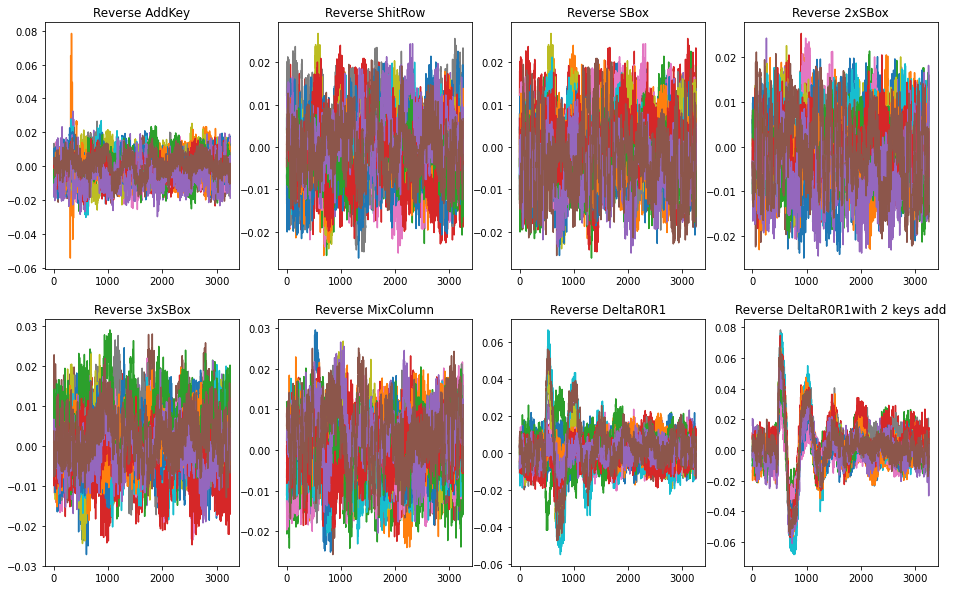

In [23]:
plt.rcParams['figure.figsize']=(16,10)
plt.subplot(241)
plt.plot(Reverse_AdK.results.T)
plt.title('Reverse AddKey')
plt.subplot(242)
plt.plot(Reverse_SR.results.T)
plt.title('Reverse ShitRow')
plt.subplot(243)
plt.plot(Reverse_SB.results.T)
plt.title('Reverse SBox')
plt.subplot(244)
plt.plot(Reverse_2xSB.results.T)
plt.title('Reverse 2xSBox')
plt.subplot(245)
plt.plot(Reverse_3xSB.results.T)
plt.title('Reverse 3xSBox')
plt.subplot(246)
plt.plot(Reverse_MXC.results.T)
plt.title('Reverse MixColumn')
plt.subplot(247)
plt.plot(Reverse_R0R1.results.T)
plt.title('Reverse DeltaR0R1')
plt.subplot(248)
plt.plot(Reverse_R0R1_2keysAdd.results.T)
plt.title('Reverse DeltaR0R1with 2 keys add')
plt.show()

----
## Leakage on the last round

In [24]:
last_round_number = 10

In [25]:
def aes_function_lastRde_SBout(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=last_round_number, after_step=scared.aes.base.Steps.SUB_BYTES)

def aes_function_lastRde_ShiftRow(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=last_round_number, after_step=scared.aes.base.Steps.SHIFT_ROWS)

def aes_function_DeltaR9R10(plaintext, key):
    tmp1 = scared.aes.encrypt(plaintext = plaintext, key = key, at_round=last_round_number-1, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)
    tmp2 = scared.aes.encrypt(plaintext = plaintext, key = key, at_round=last_round_number, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)
    return tmp1^tmp2

In [26]:
Sel_SB = scared.reverse_selection_function(aes_function_lastRde_SBout)
Sel_SR = scared.reverse_selection_function(aes_function_lastRde_ShiftRow)
Sel_R9R10 = scared.reverse_selection_function(aes_function_DeltaR9R10)

In [27]:
Reverse_SB = Distinguisher(selection_function = Sel_SB, model = model_selected)
Reverse_SR = Distinguisher(selection_function = Sel_SR, model = model_selected)
Reverse_R9R10 = Distinguisher(selection_function = Sel_R9R10, model = model_selected)

In [28]:
Reverse_SB.run(container)
Reverse_SR.run(container)
Reverse_R9R10.run(container)

### Saving the results

In [29]:
dist = 'cpa'
mod = 'HW'

In [30]:
np.save('leakage_AES_Rde10_SB_'+dist+'_'+mod, Reverse_SB.results)
np.save('leakage_AES_Rde10_SR_'+dist+'_'+mod, Reverse_SR.results)
np.save('leakage_AES_DeltaR9R10_'+dist+'_'+mod, Reverse_R9R10.results)

### Plot results

In [31]:
Reverse_R9R10 = np.load('leakage_AES_DeltaR9R10_'+dist+'_'+mod+'.npy')
Reverse_SR = np.load('leakage_AES_Rde10_SR_'+dist+'_'+mod+'.npy')
Reverse_SB = np.load('leakage_AES_Rde10_SB_'+dist+'_'+mod+'.npy')

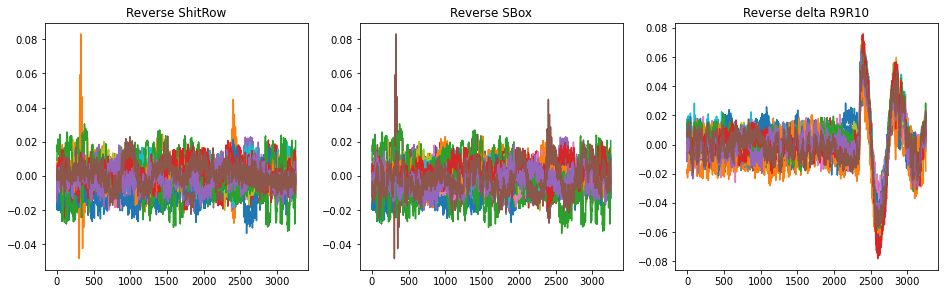

In [32]:
plt.rcParams['figure.figsize']=(16,10)
plt.subplot(231)
plt.plot(Reverse_SR.T)
plt.title('Reverse ShitRow')
plt.subplot(232)
plt.plot(Reverse_SB.T)
plt.title('Reverse SBox')
plt.subplot(233)
plt.plot(Reverse_R9R10.T)
plt.title('Reverse delta R9R10')
plt.show()